In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

2023-10-06 11:45:45.781700: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 11:45:45.844038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 11:45:46.126351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 11:45:46.128493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 11:45:48.253487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

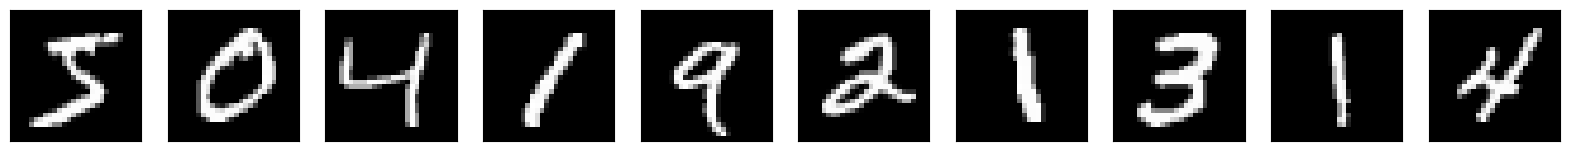

In [3]:
import matplotlib.pyplot as plt

n = 10
plt. figure(figsize = (20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt. imshow(x_train[i].reshape(28, 28))
    plt. gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
original_dim = x_train.shape[1]
latent_dim = 32

In [6]:
# Encoder
encoder_inputs = keras.Input(shape=(original_dim,))
x = layers.Dense(128, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
z = layers.Lambda(sampling)([z_mean, z_log_var])


In [9]:
# Decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)

In [10]:
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, outputs, name="decoder")

In [11]:
# Define the VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")

In [12]:
# Loss function
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [13]:
vae.compile(optimizer='adam')

vae.fit(x_train, epochs=20, batch_size=64)

# Compression and decompression
compressed_data, _, _ = encoder.predict(x_test)
reconstructed_data = decoder.predict(compressed_data)

Epoch 1/20
938/938 [==============================] - 10s 8ms/step - loss: 167.1086
Epoch 2/20
938/938 [==============================] - 9s 10ms/step - loss: 128.0593
Epoch 3/20
938/938 [==============================] - 9s 10ms/step - loss: 119.8757
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 115.9616
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 113.8637
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 112.5946
Epoch 7/20
938/938 [==============================] - 7s 7ms/step - loss: 111.6905
Epoch 8/20
938/938 [==============================] - 7s 7ms/step - loss: 111.0077
Epoch 9/20
938/938 [==============================] - 7s 7ms/step - loss: 110.5033
Epoch 10/20
938/938 [==============================] - 7s 7ms/step - loss: 110.0842
Epoch 11/20
938/938 [==============================] - 6s 7ms/step - loss: 109.7235
Epoch 12/20
938/938 [==============================] - 7s 7ms/step - loss: 109.413

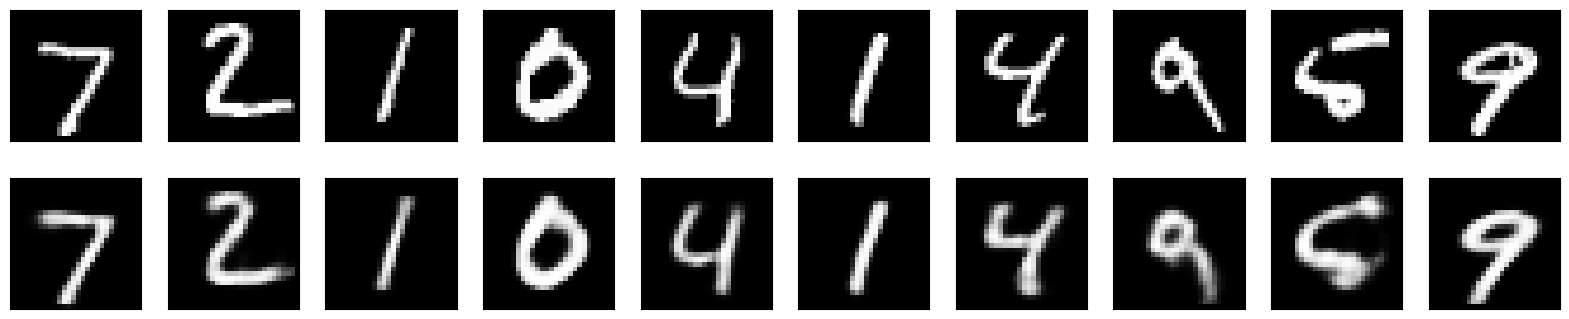

In [14]:
import matplotlib.pyplot as plt

n = 10
plt. figure(figsize = (20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt. imshow(x_test[i].reshape(28, 28))
    plt. gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt. subplot (2, n, i + 1 + n)
    plt.imshow(reconstructed_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis() .set_visible(False)
plt. show ()